In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, RMSprop
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import numpy as np
from PIL import Image
import theano
from theano import tensor as T
import os
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils, generic_utils
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
import pimpy
#from pimpy.image import factory
from pimpy.image import Image as PIm
#import leargist
import sys,tempfile,getopt,logging,io
from io import StringIO
from subprocess import *
from pimpy.image.features.feature import Feature 
import sift
import csv
import leargist

Using Theano backend.


/home/natka/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
class Sift():
    siftfeat_bin = "sift"
    swapdir = "/dev/shm"
    dim = 128
    sift_type = np.dtype([('coords',(np.float32,2)),\
                              ('scale',np.float32),\
                              ('orientation',np.float32),\
                              ('values',np.uint8,dim)])
    
    log = logging.getLogger('pimpy.image.features.sift')

    def __init__(self,**kwargs):
        Feature.__init__(self,**kwargs)
        self.log = logging.getLogger('pimpy.image.features.sift')

    def get(self,image):
            
        im = image#.get_pil_object()
        if image.format != "x-raw-gray" :
            im = im.convert('L')
        output = io.StringIO()
        impath = os.path.join(self.swapdir,"tmp.pgm")
        tmp = tempfile.NamedTemporaryFile(dir=self.swapdir,suffix=".pgm")
        im.save(tmp.name)

        self.log.debug("swap image file path %s " % tmp.name) 

        cmd = self.siftfeat_bin
        try :
            sift = Popen(cmd.split(' '),stdin=open(tmp.name),stdout=PIPE,stderr=PIPE,shell=True)
            output = sift.communicate()[0]
            self.log.debug("Sift in progress") 
            #self.log.debug(output)
            return (output.decode())
            sifts = self._parse_output(self,output)
        except OSError: 
            raise NotImplementedError("external sift program executable **%s** not available " % self.siftfeat_bin)        
        return sifts 
        
    def _parse_output(self,output):        
        lines = output.decode().split('\n')

        #first line /nb_of_features dim 
       # if (output.decode())
        print(output.decode())
        (featuresnb, dim) = [int(v) for v in lines[0].split()]
        #else 
        
        sifts = np.zeros([featuresnb],dtype=self.sift_type)

        for i in range(1,len(lines)-1 ,8):
            #firt line in block 
            y,x,scl,ori = lines[i].split()
            values = []
            #concat sift values dispatch on 7 next lines
            for j in range(1,8):
                values += lines[i+j].split()
            sifts[i/8] = ((y,x),scl,ori,values)
        return sifts 



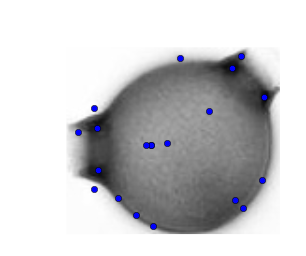

[ 50.49  53.63  11.69   2.04]
[ 0.          0.00196641  0.02752979  0.          0.          0.          0.
  0.          0.          0.00589924  0.26743222  0.24383526  0.          0.
  0.          0.          0.0884886   0.12388404  0.23793602  0.12978328
  0.          0.          0.          0.          0.08455578  0.0294962   0.
  0.          0.          0.          0.          0.          0.01966413
  0.04326109  0.04916033  0.          0.          0.00983207  0.00589924
  0.00196641  0.08258936  0.06882447  0.26743222  0.14551459  0.00589924
  0.01966413  0.04326109  0.03146261  0.26743222  0.20057417  0.11405198
  0.0589924   0.00393283  0.02556337  0.06882447  0.05112675  0.26743222
  0.15927948  0.          0.          0.          0.          0.
  0.00196641  0.02752979  0.00589924  0.          0.          0.06882447
  0.26743222  0.04129468  0.01376489  0.17894362  0.03736185  0.04326109
  0.00983207  0.01966413  0.06292523  0.03539544  0.05112675  0.26743222
  0.07669012  0.0

"\n#print(SIFTpoints)\n#print(SIFTpoints[0].shape())\nwith open('sift.csv','w',newline='') as csvfile:\n    writer=csv.writer(csvfile,delimiter=' ')#,\n                     #quotechar='|', quoting=csv.QUOTE_MINIMAL)\n    for f in range(cou):\n        writer.writerow(str(target1[f]))#str(f))\n        #print(str(f))\n        for i in range (SIFTpoints[f].shape[0]):\n            #print(SIFTpoints[f][i])\n            writer.writerow(SIFTpoints[f][i])\n            writer.writerow(SIFTdescr[f][i])\n"

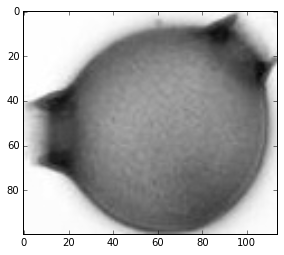

In [7]:
pollen1 = pickle.load( open( 'imgdatasethalfnorm', 'rb' ) )
target1 = pickle.load( open( 'imgtargethalf', 'rb' ) )
nb_classes=target1[target1.shape[0]-1]+1

SIFTpoints=[]
SIFTdescr=[]
i=0
#im1=Image.fromarray(pollen1[416], 'RGB')
#im1=im1.convert('L')
#im1=im1.crop((0, 0, im1.width, im1.height-9))
#im1.save("tmp1.pgm")
'''    
for f in range(pollen1.shape[0]): 
    #print(f)
    im1=Image.fromarray(pollen1[f], 'RGB')
    im1=im1.convert('L')
    #im1=im1.crop((0, 0, im1.width, im1.height - 9))
    im1.save("tmp.pgm")
    sift.process_image("tmp.pgm","tmp.key")
    l1,d1=sift.read_features_from_file("tmp.key")
    #print(l1.shape[0])
    SIFTpoints.append(l1)
    SIFTdescr.append(d1)
    #nem=str(target1[f])+str(i)+'.jpg'
    #im1.save(nem)
    #i+=1
cou=pollen1.shape[0]    

dataset_dir = u"/home/natka/local+segm"
cou=0
target1=[]
for d, dirs, files in os.walk(dataset_dir): 
 #print(d,dirs)
    images = filter(lambda x: x.endswith('.jpg'), files)     
    for f in images: 
        path = os.path.join(d,f) # формирование адреса 
        img = Image.open(path)
        im1=img#Image.fromarray(img, 'RGB')
        #im1=im1.convert('L')
        #im1=im1.crop((0, 0, im1.width, im1.height - 9))
        im1.save("tmp.pgm")
        sift.process_image("tmp.pgm","tmp.key")
        l1,d1=sift.read_features_from_file("tmp.key")
        #print(l1.shape[0])
        SIFTpoints.append(l1)
        SIFTdescr.append(d1)
        cou+=1
        print(f[6])
        plt.imshow(img)
        target1.append(f[6])
        '''
SIFTpoints=np.array(SIFTpoints)
SIFTdescr=np.array(SIFTdescr)
#надо 200 фичей
pollen1=[]
dataset_dir = u"/home/natka/local+segm"
cou=0
target1=[]
for d, dirs, files in os.walk(dataset_dir): 
 #print(d,dirs)
    images = filter(lambda x: x.endswith('.jpg'), files)     
    for f in images: 
        path = os.path.join(d,f) # формирование адреса 
        img = Image.open(path)
        pollen1.append(img)
im=PIm()
im1=pollen1[102]#Image.fromarray(pollen1[1], 'RGB')
im1=im1.convert('L')
#im1=im1.crop((0, 0, im1.width, im1.height - 9))
im1.save("tmp.pgm")
sift.process_image("tmp.pgm","tmp.key")
l1,d1=sift.read_features_from_file("tmp.key")
sift.plot_features(im1,l1)
#im.load("tmp.jpg")
print(l1[0])
print(d1[0])
plt.imshow(im1)
im1.save("sift1.jpg")
#features = Sift
#s=features.get(features,im1)
#print (s)
'''
#print(SIFTpoints)
#print(SIFTpoints[0].shape())
with open('sift.csv','w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=' ')#,
                     #quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for f in range(cou):
        writer.writerow(str(target1[f]))#str(f))
        #print(str(f))
        for i in range (SIFTpoints[f].shape[0]):
            #print(SIFTpoints[f][i])
            writer.writerow(SIFTpoints[f][i])
            writer.writerow(SIFTdescr[f][i])
'''         